In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.ndimage.filters import convolve as convolve
import glob
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
# # for full data in .mat files:
# high level dictionary keys:  ['dtfixed','timestamps','trx']
# trx struct values:  
#     x
#     y
#     theta
#     a
#     b
#     id
#     moviename
#     annname
#     firstframe
#     arena
#     off
#     nframes
#     endframe
#     timestamps
#     matname
#     x_mm
#     y_mm
#     a_mm
#     b_mm
#     theta_mm
#     dt
#     fps
#     pxpermm
#     sex

#  Definitions, misc and kernel for smoothing

In [ ]:
datadir = '/media/jacob/JD_DATA/zfish/' 

kernel values:   [0.05 0.24 0.4  0.24 0.05]


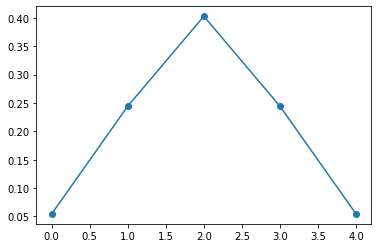

In [3]:
dt=1/60
pxpercm = 4.02361434 * 10  # from tracker

def fixanglerange(angles): # Puts all angles into a range of [-Pi,Pi]
    return np.arctan2(np.sin(angles),np.cos(angles))

sigma=1  # for smoothing of trajectories with a half Gaussian filter  (only the left part of the Gaussian is used)

# create kernel for smoothing
# convolve
x_for_kernel = np.arange(-10, 10)
# Calculate kernel
kernel = np.exp(-(x_for_kernel) ** 2 / (2 * sigma ** 2))

## Use this line to smooth with a half-Gaussian:
# kernel[x_for_kernel>0]=0

# Threshold the kernel and re-normalize
kernel_above_thresh = kernel > 0.05  # use a higher threshold, so it doesn't go back as many frames
finite_kernel = kernel[kernel_above_thresh]
finite_kernel = finite_kernel / finite_kernel.sum()
# with this, use the scipy function to smooth. for example:  convolved_x = convolve(data_x[0], finite_kernel, mode='nearest')

plt.plot(finite_kernel,'-o')
print('kernel values:  ',np.round(finite_kernel,2))

# Loop through all the .mat tracking files, and output as pickle files that are easier to work with

In [ ]:
# loop through all the files, and output as pickle files that are easier to work with

for gnum in range(3):
    print('\n\n\n group', gnum)

    groupdatadir = datadir+'g'+str(gnum)+'/'
    treatments = [str.split(s,'/')[-2] for s in sorted(glob.glob(groupdatadir+"/*"+ os.path.sep))]
    print(treatments)

    for tnum in range(0,len(treatments)):
        treatment = treatments[tnum]
        print('\n',treatment)
        datafiles = np.sort([str.split(s,'/')[-1] for s in glob.glob(groupdatadir+treatment+'/*mat')])

        trial_speeds = []
        trial_headings = []
        trial_trajectories = []
        trial_theta = []

        trial_smoothspeeds = []
        trial_smoothheadings = []
        trial_smoothtrajectories = []

        trial_ellipses = []
        trial_arena = []
        trial_sex = []
        
        trial_trackingerrors = []


        for file in datafiles:
            print(file)
            # full data
            data = loadmat(groupdatadir+treatment+'/'+file)
            def loadval(dictval):
                return np.array([t[0][0] for t in (np.array(data['trx'][dictval]).T)]) 
            data_x = loadval('x')
            data_y = loadval('y')
            data_a = loadval('a')  # ellipse parameter a
            data_b = loadval('b')  # ellipse parameter b
            theta = loadval('theta')  # not using this, could remove
            arena = loadval('arena')[0]
            sex = loadval('sex')[:,0]  # this is stored for each frame, but just keep the first one

            trajectories = np.array([data_x,data_y]).T
            ellipses = np.array([data_a,data_b]).T

            numsteps = trajectories.shape[0]
            numfish = trajectories.shape[1]



            # filter the data, by removing high acceleratoins
            # This takes out 'back and forth' type tracking errors
            
            # also remove the weird 'constant speed' tracking errors

            velocities = np.gradient(trajectories,axis=0)/dt
            speeds = np.sqrt(velocities[:,:,0]**2 + velocities[:,:,1]**2)
            # Calculate acceleration, and then set a cut-off
            accel = np.gradient(speeds,axis=0)
            accel[1:] = speeds[1:]-speeds[0:-1]  # this is lazy, but its fast anyways.  Use a simple difference
            speedsraw = speeds.copy()

            def consecutive(data):
                return np.split(data, np.where(np.diff(data) != 0)[0]+1)

            accelthreshold = 450  # use this to filter acceleration  
            # to convert to accel units:  450/dt/pxpercm
            # remember to put in the units for the write up
            # this is approx 6 times the IQR of the abs value of accel for a WT trial (first WT trial)


            for i in range(numfish):
                data=np.abs(accel[:,i].copy())
#                 remove consecutive segments with zero accel and high speed, these are not correct
                minzerolength=3
                todrop = (np.abs(data)<0.001)
                todropspeed = (speeds[:,i]>231.32896269)  #this is the median of the combined speed distribution
                seg=consecutive(todrop&todropspeed)
                for s in range(len(seg)):
                    if (np.all(seg[s]))&(len(seg[s])<minzerolength):
                        seg[s]=np.full(len(seg[s]),False)
                data[np.hstack(seg)] = np.nan

                # now remove accel points that are really high, even if they are in a segment:
                data[np.abs(data)>accelthreshold] = np.nan

                # save and move on
                accel[:,i] = data

            trackingerrors = np.isnan(accel)
            trajectories[trackingerrors]=np.nan
            
            # smoothing of trajectories using half-Gaussian kernel
            # UPDATE JULY 27:  USING FULL GAUSSIAN INSTEAD
            smoothtrajectories = trajectories.copy()
            for i in range(numfish):
                smoothtrajectories[:,i,0] = convolve(trajectories[:,i,0], finite_kernel, mode='nearest')
                smoothtrajectories[:,i,1] = convolve(trajectories[:,i,1], finite_kernel, mode='nearest')            

            # replace nan locations with interpolations for trajectories
            for i in range(numfish):
                for c in range(2):
                    val=smoothtrajectories[:,i,c].copy()
                    def nan_helper(val):
                        return np.isnan(val), lambda z: z.nonzero()[0]
                    nans, q= nan_helper(val)
                    val[nans] = np.interp(q(nans), q(~nans), val[~nans])
                    smoothtrajectories[:,i,c] = val

            #  and recalculate velocity and speed

            velocities = np.gradient(trajectories,axis=0)/dt
            speeds = np.sqrt(velocities[:,:,0]**2 + velocities[:,:,1]**2)
            headings = np.arctan2(velocities[:,:,1],velocities[:,:,0]) 
            accel = np.gradient(speeds,axis=0)    


            # quantities calculated from the smoothed trajectories        
            smoothvelocities = np.gradient(smoothtrajectories,axis=0)/dt        
            smoothspeeds = np.sqrt(smoothvelocities[:,:,0]**2 + smoothvelocities[:,:,1]**2)              
            smoothheadings = np.arctan2(smoothvelocities[:,:,1],smoothvelocities[:,:,0])       
            angvel = fixanglerange(np.gradient(smoothheadings,axis=0))/dt    
            # this needs to be 'trajectories', not 'smoothtrajectories'
            trackingerrors = np.isnan(trajectories[:,:,0])  #  this has the same dimensions as speeds:  [frame,fish]

            # ADD TO ARRAY TO SAVE
            trial_speeds.append(speeds)
            trial_trajectories.append(trajectories)
            trial_headings.append(headings)
            trial_theta.append(theta)

            trial_smoothspeeds.append(smoothspeeds)
            trial_smoothtrajectories.append(smoothtrajectories)
            trial_smoothheadings.append(smoothheadings)

            trial_ellipses.append(ellipses)
            trial_arena.append(arena)
            trial_sex.append(sex)
            
            trial_trackingerrors.append(trackingerrors)

        # OUTPUT TO PICKLE FILE FOR EASY READING IN
        # note for this, don't use gzip, because even though the savings in file size is reasonable (approx 25% smaller), it takes about 10 times longer to load
        pfile = datadir+treatment+'-alltrials.pkl'
        pickle.dump([trial_speeds,trial_trajectories,trial_headings,trial_theta,
                    trial_smoothspeeds,trial_smoothtrajectories,trial_smoothheadings,
                    trial_ellipses,trial_arena,trial_sex,
                    datafiles,trial_trackingerrors],
                    open(pfile,'wb'))
        print('wrote to: ' + pfile)